In [1]:
import json

In [2]:
from NewsSentiment import TargetSentimentClassifier

class SentimentAnalyser:

    def __init__(self):
        self.tsc = TargetSentimentClassifier()
    
    def bounds_sentiment(self, mention_start, mention_end, sentence_start, sentence_end,
                         article_text, database_id):
        try:
            left_segment = article_text[sentence_start:mention_start]
            mention_segment = article_text[mention_start:mention_end]
            right_segment = article_text[mention_end:sentence_end]
    
    
            sentiment = self.tsc.infer_from_text(left_segment, mention_segment, right_segment)
            # print(sentiment[0])
    
            result = {
                "sentiment": sentiment[0],
                "left_segment": left_segment,
                "mention_segment": mention_segment,
                "right_segment": right_segment
            }
    
            return result
    
    
        except Exception as e:
            print(f"Error during sentiment analysis: {e}")
            print(f"LEFT: {left_segment}")
            print(f"MENTION: {mention_segment}")
            print(f"RIGHT: {right_segment}")
    
            error_result = {
                "article_id": database_id,
                "bound_start": mention_start,
                "bound_end": mention_end,
                "left_segment": left_segment,
                "mention_segment": mention_segment,
                "right_segment": right_segment,
                "error_message": f"Exception during sentiment analysis: {str(e)}"
            }
    
            print(json.dumps(error_result))

        return None

In [3]:
def process_input_file(sentiment_analyzer, input_file_path, output_file_path):
    with open(input_file_path, 'r') as infile, open(output_file_path, 'w') as outfile:
        total_lines = sum(1 for _ in infile)
        infile.seek(0)  # Reset file pointer to the beginning.

        for line_number, line in enumerate(infile, start=1):
            data = json.loads(line)
            process_targets(data, sentiment_analyzer)

            # Write the updated data back to the output file.
            outfile.write(json.dumps(data) + '\n')

            print_progress(line_number, total_lines)

def process_targets(data, sentiment_analyzer):
    if 'targets' in data:
        for target in data['targets']:
            process_target(target, data['sentence_normalized'], data['primary_gid'], sentiment_analyzer)
            # if 'further_mentions' in target:
            #     for further_mention in target['further_mentions']:
            #         process_target(further_mention, data['sentence_normalized'], data['primary_gid'], sentiment_analyzer)

def process_target(target, sentence_normalized, primary_gid, sentiment_analyzer):
    mention_start = target["from"]
    mention_end = target["to"]
    mention = target["mention"]
    polarity = target["polarity"]

    result = sentiment_analyzer.bounds_sentiment(
        mention_start, mention_end, 0, len(sentence_normalized),
        sentence_normalized, primary_gid
    )

    target["result"] = result

    polarity_string = get_polarity_string(polarity)
    print_mention_details(mention, polarity_string, result)

def get_polarity_string(polarity):
    mapping = {
        2.0: "Negative",
        4.0: "Neutral",
        6.0: "Positive"
    }
    return mapping.get(polarity, "POLARITY STRING ERROR")

def print_progress(line_number, total_lines):
    print(f"Processing line {line_number}/{total_lines}")

def print_mention_details(mention, polarity_string, result):
    print(mention)
    print(f"News MTSC Polarity: {polarity_string}")
    print(f"News Sentiment: {result['sentiment']['class_label']}")



In [4]:
sentiment_analyzer = SentimentAnalyser()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
input_file_path = "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/NewsMTSC/NewsMTSC-dataset/train.jsonl"
output_file_path = ("/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/NewsMTSC"
                    "/News_Sentiment_Appended/train_output.json")
# process_input_file(sentiment_analyzer ,input_file_path, output_file_path)

In [6]:
input_file_path = ("/Users/ameek/FY-Project/Notebook_Phase/NewsMTSC/NewsMTSC-dataset/devtest_mt"
                   ".jsonl")
output_file_path = ("/Users/ameek/FY-Project/Notebook_Phase/NewsMTSC/News_Sentiment_Appended"
                    "/devtest_mt_output.json")
# process_input_file(sentiment_analyzer ,input_file_path, output_file_path)

In [7]:
input_file_path = ("/Users/ameek/FY-Project/Notebook_Phase/NewsMTSC/NewsMTSC-dataset/devtest_rw"
                   ".jsonl")
output_file_path = ("/Users/ameek/FY-Project/Notebook_Phase/NewsMTSC/News_Sentiment_Appended"
                    "/devtest_rw_output.json")
# process_input_file(sentiment_analyzer ,input_file_path, output_file_path)

In [18]:
import json
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

file_paths = [
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/NewsMTSC/News_Sentiment_Appended/train_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/NewsMTSC/News_Sentiment_Appended/devtest_rw_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/NewsMTSC"
    "/News_Sentiment_Appended/devtest_mt_output.json"
]

results = []

for file_path in file_paths:
    processed_data = []
    with open(file_path, 'r') as file:
        for line in file:
            try:
                json_line = json.loads(line)
                for target in json_line.get('targets', []):
                    true_label = target.get('polarity')
                    predicted_label = target.get('result', {}).get('sentiment', {}).get('class_label')
                    processed_data.append({
                        'true_label': true_label,
                        'predicted_label': predicted_label
                    })
            except json.JSONDecodeError:
                print(f"Error decoding JSON line: {line}")
            except AttributeError:
                # print(f"Error decoding JSON line: {line}")
                # print(f"Attribute error skipping line")
                print('skip')
    
    df = pd.DataFrame(processed_data)
    
    # Mad TSC datasets use 2,4,6 for negative, neutral and positive
    polarity_mapping = {
        2.0: 'negative',
        4.0: 'neutral',
        6.0: 'positive'
    }
    df['true_label'] = df['true_label'].map(polarity_mapping)
    
    accuracy = accuracy_score(df['true_label'], df['predicted_label'])
    
    precision, recall, f1, _ = precision_recall_fscore_support(df['true_label'], df['predicted_label'], average='weighted')
    
    conf_matrix = confusion_matrix(df['true_label'], df['predicted_label'])
    
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.9042224510813595
Precision: 0.9050321951083717
Recall: 0.9042224510813595
F1-Score: 0.9044442664165849
Confusion Matrix:
 [[3035  180  101]
 [ 129 2743  156]
 [  54  217 2124]]
Accuracy: 0.8403141361256544
Precision: 0.8417106808216119
Recall: 0.8403141361256544
F1-Score: 0.8395866910406538
Confusion Matrix:
 [[368  41  20]
 [ 21 406  28]
 [ 19  54 189]]
skip
skip
skip
Accuracy: 0.8470428280081577
Precision: 0.8478687124629896
Recall: 0.8470428280081577
F1-Score: 0.8453514168394981
Confusion Matrix:
 [[410  67   5]
 [ 56 667  21]
 [ 18  58 169]]


## News MTSC Dataset


Original Accuracy: 0.9042224510813595
Original Precision: 0.9050321951083717
Original Recall: 0.9042224510813595
Original F1-Score: 0.9044442664165849
Original Confusion Matrix:
 [[3035  180  101]
 [ 129 2743  156]
 [  54  217 2124]]
/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/NewsMTSC/News_Sentiment_Appended/train_output.json


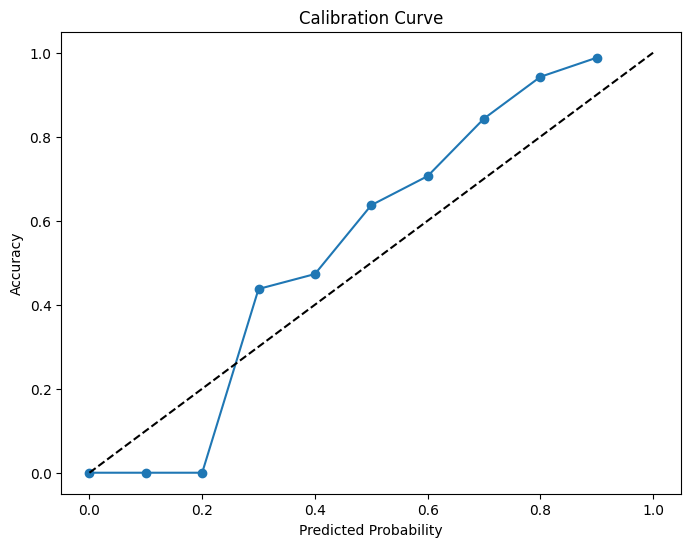

Number of items in each bin:
class_prob
9    4565
8    1742
7     944
6     691
5     540
4     241
3      16
Name: count, dtype: int64
Original Accuracy: 0.8403141361256544
Original Precision: 0.8417106808216119
Original Recall: 0.8403141361256544
Original F1-Score: 0.8395866910406538
Original Confusion Matrix:
 [[368  41  20]
 [ 21 406  28]
 [ 19  54 189]]
/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/NewsMTSC/News_Sentiment_Appended/devtest_rw_output.json


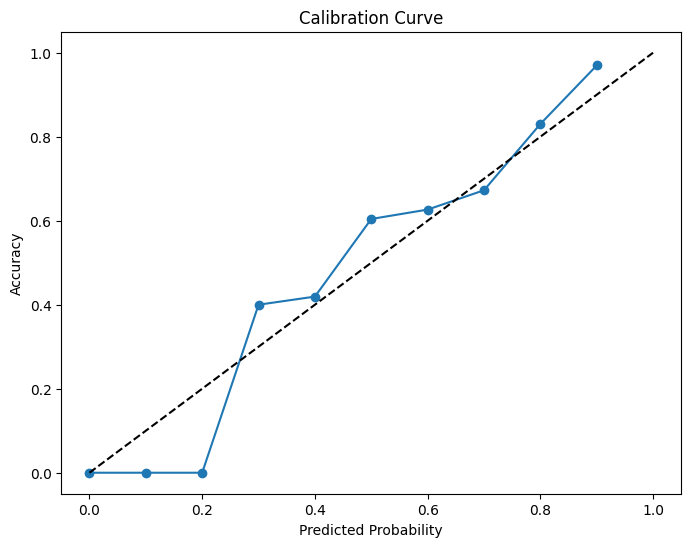

Number of items in each bin:
class_prob
9    594
8    224
7    113
5     96
6     83
4     31
3      5
Name: count, dtype: int64



Original Accuracy: 0.8470428280081577
Original Precision: 0.8478687124629896
Original Recall: 0.8470428280081577
Original F1-Score: 0.8453514168394981
Original Confusion Matrix:
 [[410  67   5]
 [ 56 667  21]
 [ 18  58 169]]
/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/NewsMTSC/News_Sentiment_Appended/devtest_mt_output.json


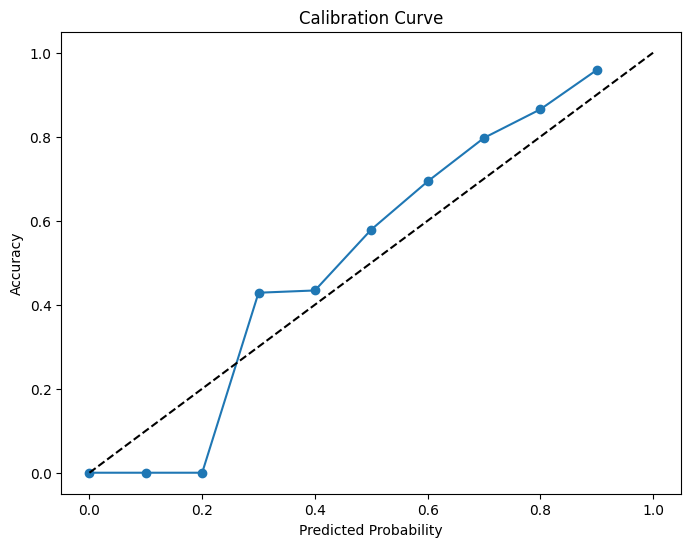

Number of items in each bin:
class_prob
9    729
8    282
7    143
5    133
6    124
4     53
3      7
Name: count, dtype: int64


In [1]:
import matplotlib.pyplot as plt
import numpy as np

import json
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

file_paths = [
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/NewsMTSC/News_Sentiment_Appended/train_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/NewsMTSC/News_Sentiment_Appended/devtest_rw_output.json",
    "/Users/ameek/FY-Project/Notebook_Phase/News_Sentiment_Evaluation/NewsMTSC"
    "/News_Sentiment_Appended/devtest_mt_output.json"
]

# Threshold for class probability
threshold = 0.0

for file_path in file_paths:
    processed_data = []
    with open(file_path, 'r') as file:
        
        for line in file:
            try:
                json_line = json.loads(line)
                for target in json_line['targets']:
                    true_label = target['polarity']
                    predicted_label = target['result']['sentiment']['class_label']
                    class_prob = target['result']['sentiment']['class_prob']
                    # Apply threshold
                    predicted_label_thresholded = predicted_label if class_prob > threshold else 'ignore'
                    processed_data.append({
                        'true_label': true_label,
                        'predicted_label': predicted_label,
                        'class_prob': class_prob,
                        'predicted_label_thresholded': predicted_label_thresholded
                    })
            except json.JSONDecodeError:
                print(f"Error decoding JSON line: {line}")
            except AttributeError:
                # print(f"Error decoding JSON line: {line}")
                print('')
            except TypeError:
                # print(f"Error decoding JSON line: {line}")
                print('')
                
                
    df = pd.DataFrame(processed_data)
    
    # Mapping for polarity
    polarity_mapping = {
        2.0: 'negative',
        4.0: 'neutral',
        6.0: 'positive'
    }
    df['true_label'] = df['true_label'].map(polarity_mapping)

    accuracy = accuracy_score(df['true_label'], df['predicted_label'])
    precision, recall, f1, _ = precision_recall_fscore_support(df['true_label'], df['predicted_label'], average='weighted')
    conf_matrix = confusion_matrix(df['true_label'], df['predicted_label'])
    
    # Print Original Results
    print("Original Accuracy:", accuracy)
    print("Original Precision:", precision)
    print("Original Recall:", recall)
    print("Original F1-Score:", f1)
    print("Original Confusion Matrix:\n", conf_matrix)

    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)

    # Bin/divide up the probabilities
    bins = pd.cut(df['class_prob'], bins=bin_edges, include_lowest=True, labels=False)
    
    # Calculating accuracy for each bin
    bin_accuracy = df.groupby(bins).apply(lambda x: accuracy_score(x['true_label'], x['predicted_label']) if not x.empty else 0)
    
    # Ensuring each bin has a value (fill missing bins with 0)
    bin_accuracy = bin_accuracy.reindex(range(n_bins), fill_value=0)
    

    print(file_path)
    plt.figure(figsize=(8, 6))
    plt.plot(bin_edges[:-1], bin_accuracy, marker='o')
    plt.plot([0, 1], [0, 1], 'k--') # Ideal line
    plt.xlabel('Predicted Probability')
    plt.ylabel('Accuracy')
    plt.title('Calibration Curve')
    plt.show()
    
    print("Number of items in each bin:")
    print(bins.value_counts())
    